In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re, nltk, stop_words
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/onion-or-not/OnionOrNot.csv


# IMPORT ALL DATASETS

In [2]:
dffake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
dfreal = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
dfsatire = pd.read_csv("../input/onion-or-not/OnionOrNot.csv")

In [3]:
dffake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

Set class identifier, type = 1 for fakenews = true

In [4]:
dffake['Type'] = 1

In [5]:
dffake.shape

(23481, 5)

In [6]:
dfreal.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

set class identifier type = 0 for fakenews = false

In [7]:
dfreal['Type'] = 0

In [8]:
dfreal.shape

(21417, 5)

In [9]:
dfsatire.head()

text  label
0  Entire Facebook Staff Laughs As Man Tightens P...      1
1  Muslim Woman Denied Soda Can for Fear She Coul...      0
2  Bold Move: Hulu Has Announced That They’re Gon...      1
3  Despondent Jeff Bezos Realizes He’ll Have To W...      1
4  For men looking for great single women, online...      1

Original dataset class label 0 = not satire 1 = satire
0 and 1 identifiers already used for real and fake classification, label satirical articles as 3.

In [10]:
dfsatire["label"].replace({1: 3}, inplace=True)
dfsatire.rename(columns={'label': 'Type'}, inplace=True)

Merge fake and real datasets

In [11]:
dffakereal = pd.concat([dffake,dfreal], axis=0,ignore_index=True)

In [12]:
dffakereal.shape

(44898, 5)

In [13]:
dffakereal.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  Type  
0  December 31, 2017     1  
1  December 31, 2017     1  
2  December 30, 2017     1  
3  December 29, 2017     1  
4  December 25, 2017     1

Shuffle dataset

In [14]:
dffakereal = dffakereal.sample(frac=1)

In [15]:
dffakereal.head()

title  \
44754  Losing immunity, German anti-immigrant party's...   
20188  BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...   
34339  Defense Department promises plan to defeat Isl...   
31268  North Carolina police probe arson, graffiti th...   
4961    Campaign Manager: ‘I’m White, I Was Moved’ By...   

                                                    text       subject  \
44754  BERLIN (Reuters) - A regional parliament has l...     worldnews   
20188                    You can run but you can t hide      left-news   
34339  WASHINGTON (Reuters) - The U.S. Department of ...  politicsNews   
31268  WINSTON-SALEM, N.C. (Reuters) - Police in Nort...  politicsNews   
4961   Republican presidential candidate Donald Trump...          News   

                     date  Type  
44754    August 29, 2017      0  
20188        Jul 31, 2016     1  
34339  February 12, 2016      0  
31268   October 17, 2016      0  
4961      August 21, 2016     1

Check fake news to real news split

In [16]:
print(dffakereal.groupby('Type')['text'].count())

Type
0    21417
1    23481
Name: text, dtype: int64


Drop irrelevant columns

In [17]:
dffakereal.drop('subject', axis=1, inplace=True)
dffakereal.drop('date', axis=1, inplace=True)

In [18]:
dffakereal.head()

title  \
44754  Losing immunity, German anti-immigrant party's...   
20188  BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...   
34339  Defense Department promises plan to defeat Isl...   
31268  North Carolina police probe arson, graffiti th...   
4961    Campaign Manager: ‘I’m White, I Was Moved’ By...   

                                                    text  Type  
44754  BERLIN (Reuters) - A regional parliament has l...     0  
20188                    You can run but you can t hide      1  
34339  WASHINGTON (Reuters) - The U.S. Department of ...     0  
31268  WINSTON-SALEM, N.C. (Reuters) - Police in Nort...     0  
4961   Republican presidential candidate Donald Trump...     1

In [19]:
nltk.download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Feature cleaning, removing unncessary words

Words found in stopwords database or if word consists of 3 or less characters are not returned through 'result', they are removed.

In [20]:
def preprocess(text):
    result = []
    # Convert string into list of tokens(words) and iterate through them
    for token in gensim.utils.simple_preprocess(text):
        # If token (word) is not found in gensim stopwords, greater than 3 characters long and not in stop_words database, the word is appended to the output 'result'
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

# Apply feature cleaning function (preprocess) to dataframe

In [21]:
dffakereal['cleantext'] = dffakereal['text'].apply(preprocess)
dffakereal['cleantitle'] = dffakereal['title'].apply(preprocess)

title -> cleantitle (feature cleaning applied)

text -> cleantext (feature cleaning applied)

In [22]:
dffakereal.head()

title  \
44754  Losing immunity, German anti-immigrant party's...   
20188  BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...   
34339  Defense Department promises plan to defeat Isl...   
31268  North Carolina police probe arson, graffiti th...   
4961    Campaign Manager: ‘I’m White, I Was Moved’ By...   

                                                    text  Type  \
44754  BERLIN (Reuters) - A regional parliament has l...     0   
20188                    You can run but you can t hide      1   
34339  WASHINGTON (Reuters) - The U.S. Department of ...     0   
31268  WINSTON-SALEM, N.C. (Reuters) - Police in Nort...     0   
4961   Republican presidential candidate Donald Trump...     1   

                                               cleantext  \
44754  [berlin, reuters, regional, parliament, lifted...   
20188                                             [hide]   
34339  [washington, reuters, department, defense, soo...   
31268  [winston, salem, reuters, police, north, carol...   
4961   [republican, presidential, candidate, donald, ...   

                                              cleantitle  
44754  [losing, immunity, german, anti, immigrant, pa...  
20188  [brutal, benghazi, exposes, hillary, embarrass...  
34339  [defense, department, promises, plan, defeat, ...  
31268  [north, carolina, police, probe, arson, graffi...  
4961   [campaign, manager, white, moved, trump, remar...

First article prior to feature cleaning

In [23]:
dffakereal['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

First article post feature cleaning

In [24]:
dffakereal['cleantext'][0]

['donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'year',
 'leave',
 'instead',
 'shout',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'reality',
 'star',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'year',
 'great',
 'year',
 'america',
 'donald',
 'trump',
 'realdonaldtrump',
 'december',
 'trump',
 'tweet',
 'went',
 'welll',
 'expect',
 'kind',
 'president',
 'sends',
 'year',
 'greeting',
 'like',
 'despicable',
 'petty',
 'infantile',
 'gibberish',
 'trump',
 'lack',
 'decency',
 'allow',
 'rise',
 'gutter',
 'long',
 'wish',
 'american'

In [25]:
dffakereal.head()

title  \
44754  Losing immunity, German anti-immigrant party's...   
20188  BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...   
34339  Defense Department promises plan to defeat Isl...   
31268  North Carolina police probe arson, graffiti th...   
4961    Campaign Manager: ‘I’m White, I Was Moved’ By...   

                                                    text  Type  \
44754  BERLIN (Reuters) - A regional parliament has l...     0   
20188                    You can run but you can t hide      1   
34339  WASHINGTON (Reuters) - The U.S. Department of ...     0   
31268  WINSTON-SALEM, N.C. (Reuters) - Police in Nort...     0   
4961   Republican presidential candidate Donald Trump...     1   

                                               cleantext  \
44754  [berlin, reuters, regional, parliament, lifted...   
20188                                             [hide]   
34339  [washington, reuters, department, defense, soo...   
31268  [winston, salem, reuters, police, north, carol...   
4961   [republican, presidential, candidate, donald, ...   

                                              cleantitle  
44754  [losing, immunity, german, anti, immigrant, pa...  
20188  [brutal, benghazi, exposes, hillary, embarrass...  
34339  [defense, department, promises, plan, defeat, ...  
31268  [north, carolina, police, probe, arson, graffi...  
4961   [campaign, manager, white, moved, trump, remar...

Join the extracted article features into a string

In [26]:
dffakereal['joinedtext'] = dffakereal['cleantext'].apply(lambda x: " ".join(x))
dffakereal['joinedtitle'] = dffakereal['cleantitle'].apply(lambda x: " ".join(x))

In [27]:
dffakereal.head()

title  \
44754  Losing immunity, German anti-immigrant party's...   
20188  BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...   
34339  Defense Department promises plan to defeat Isl...   
31268  North Carolina police probe arson, graffiti th...   
4961    Campaign Manager: ‘I’m White, I Was Moved’ By...   

                                                    text  Type  \
44754  BERLIN (Reuters) - A regional parliament has l...     0   
20188                    You can run but you can t hide      1   
34339  WASHINGTON (Reuters) - The U.S. Department of ...     0   
31268  WINSTON-SALEM, N.C. (Reuters) - Police in Nort...     0   
4961   Republican presidential candidate Donald Trump...     1   

                                               cleantext  \
44754  [berlin, reuters, regional, parliament, lifted...   
20188                                             [hide]   
34339  [washington, reuters, department, defense, soo...   
31268  [winston, salem, reuters, police, north, carol...   
4961   [republican, presidential, candidate, donald, ...   

                                              cleantitle  \
44754  [losing, immunity, german, anti, immigrant, pa...   
20188  [brutal, benghazi, exposes, hillary, embarrass...   
34339  [defense, department, promises, plan, defeat, ...   
31268  [north, carolina, police, probe, arson, graffi...   
4961   [campaign, manager, white, moved, trump, remar...   

                                              joinedtext  \
44754  berlin reuters regional parliament lifted immu...   
20188                                               hide   
34339  washington reuters department defense soon sub...   
31268  winston salem reuters police north carolina so...   
4961   republican presidential candidate donald trump...   

                                             joinedtitle  
44754  losing immunity german anti immigrant party he...  
20188  brutal benghazi exposes hillary embarrassing i...  
34339  defense department promises plan defeat islami...  
31268  north carolina police probe arson graffiti thr...  
4961   campaign manager white moved trump remarks bla...

first article prior to all feature cleaning

In [28]:
dffakereal['cleantext'][0]

['donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'year',
 'leave',
 'instead',
 'shout',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'reality',
 'star',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'year',
 'great',
 'year',
 'america',
 'donald',
 'trump',
 'realdonaldtrump',
 'december',
 'trump',
 'tweet',
 'went',
 'welll',
 'expect',
 'kind',
 'president',
 'sends',
 'year',
 'greeting',
 'like',
 'despicable',
 'petty',
 'infantile',
 'gibberish',
 'trump',
 'lack',
 'decency',
 'allow',
 'rise',
 'gutter',
 'long',
 'wish',
 'american'

First article after feature extraction and string formation.

In [29]:
dffakereal['joinedtext'][0]

'donald trump wish americans happy year leave instead shout enemies haters dishonest fake news media reality star country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy year president angry pants tweeted great year america country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy year great year america donald trump realdonaldtrump december trump tweet went welll expect kind president sends year greeting like despicable petty infantile gibberish trump lack decency allow rise gutter long wish american citizens happy year bishop talbert swan talbertswan december likes calvin calvinstowell december impeachment great year america accept regaining control congress miranda yaver mirandayaver december hear talk include people hate wonder hate alan sandoval alansandoval december uses word haters years wish marlene marlene december happy year koren pollitt korenca

In [30]:
#Drop unneeded columns
dffakereal.drop('title', axis=1, inplace=True)
dffakereal.drop('text', axis=1, inplace=True)
dffakereal.drop('cleantext', axis=1, inplace=True)
dffakereal.drop('cleantitle', axis=1, inplace=True)

In [31]:
dffakereal.head()

Type                                         joinedtext  \
44754     0  berlin reuters regional parliament lifted immu...   
20188     1                                               hide   
34339     0  washington reuters department defense soon sub...   
31268     0  winston salem reuters police north carolina so...   
4961      1  republican presidential candidate donald trump...   

                                             joinedtitle  
44754  losing immunity german anti immigrant party he...  
20188  brutal benghazi exposes hillary embarrassing i...  
34339  defense department promises plan defeat islami...  
31268  north carolina police probe arson graffiti thr...  
4961   campaign manager white moved trump remarks bla...

In [32]:
y = dffakereal['Type']
x = dffakereal['joinedtitle']

# Word cloud generation

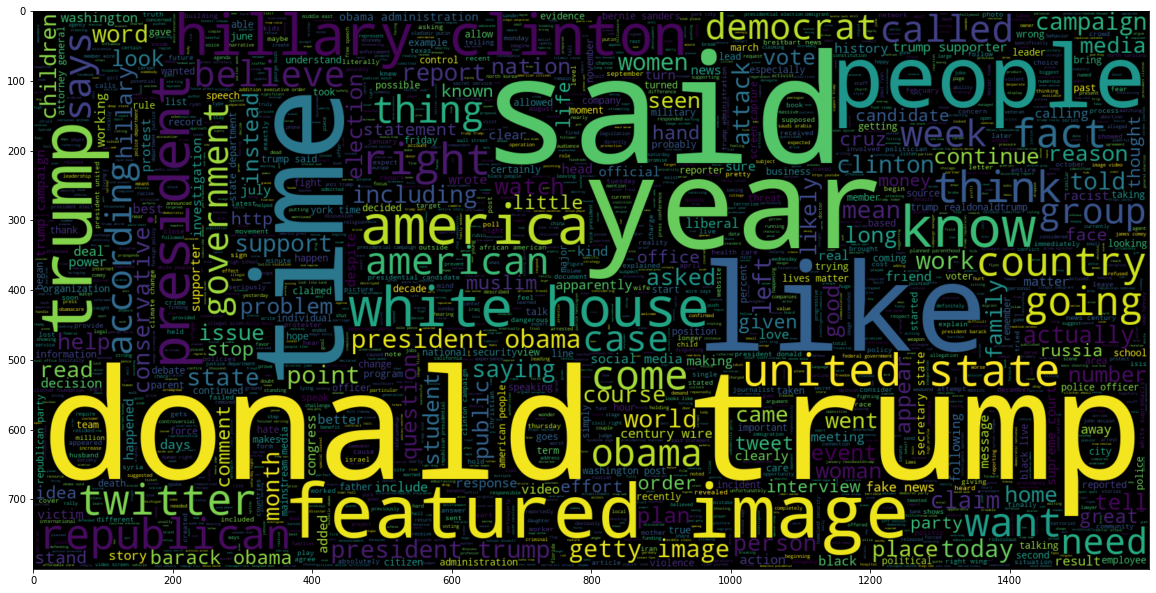

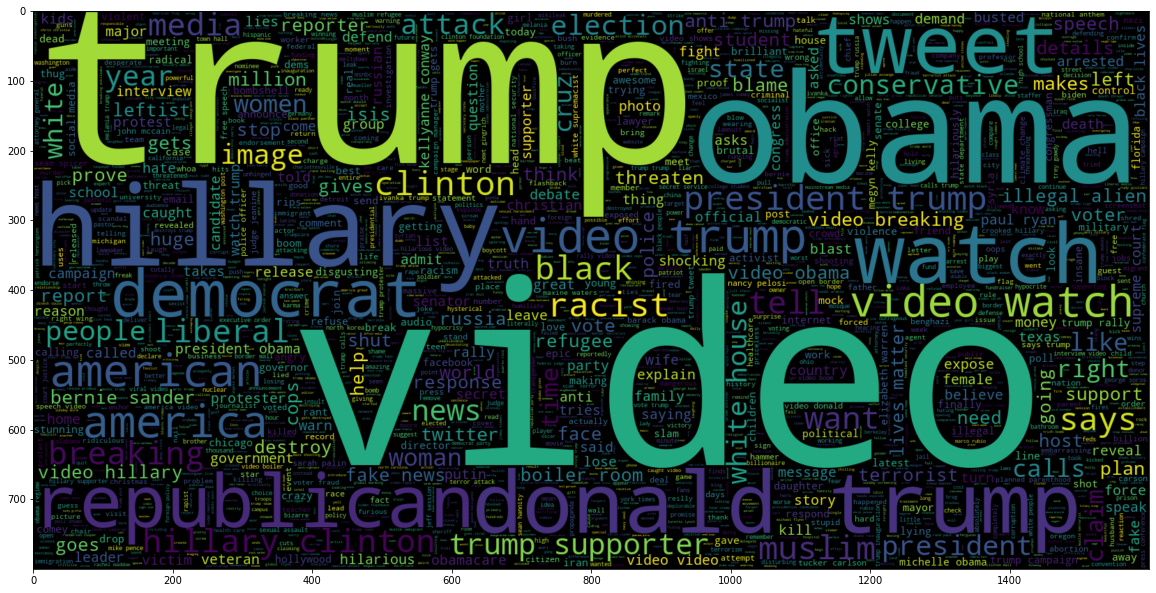

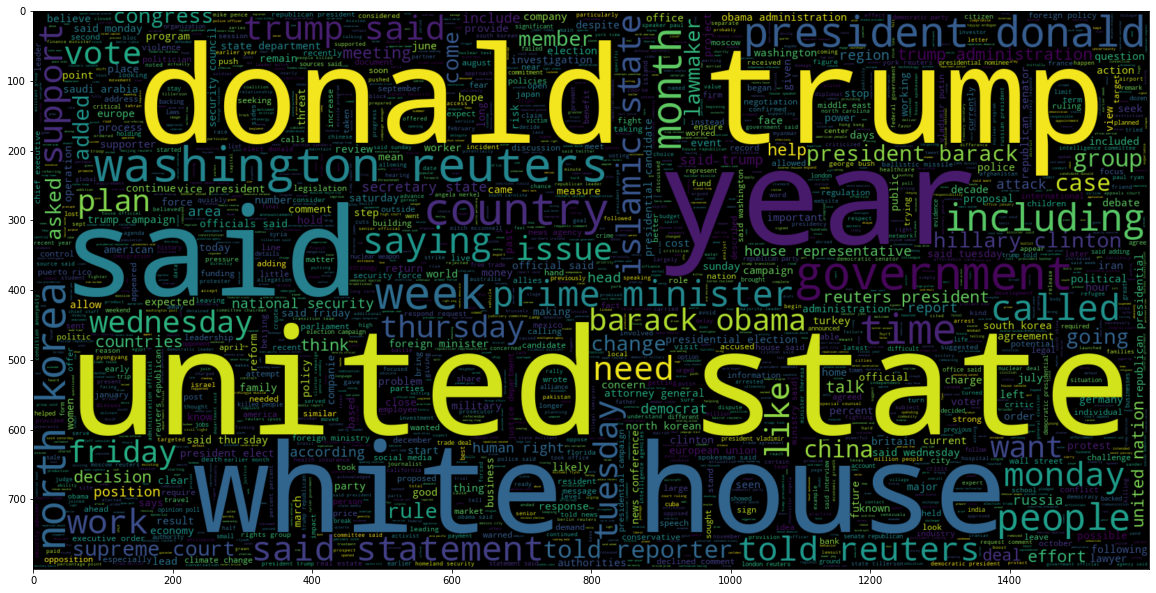

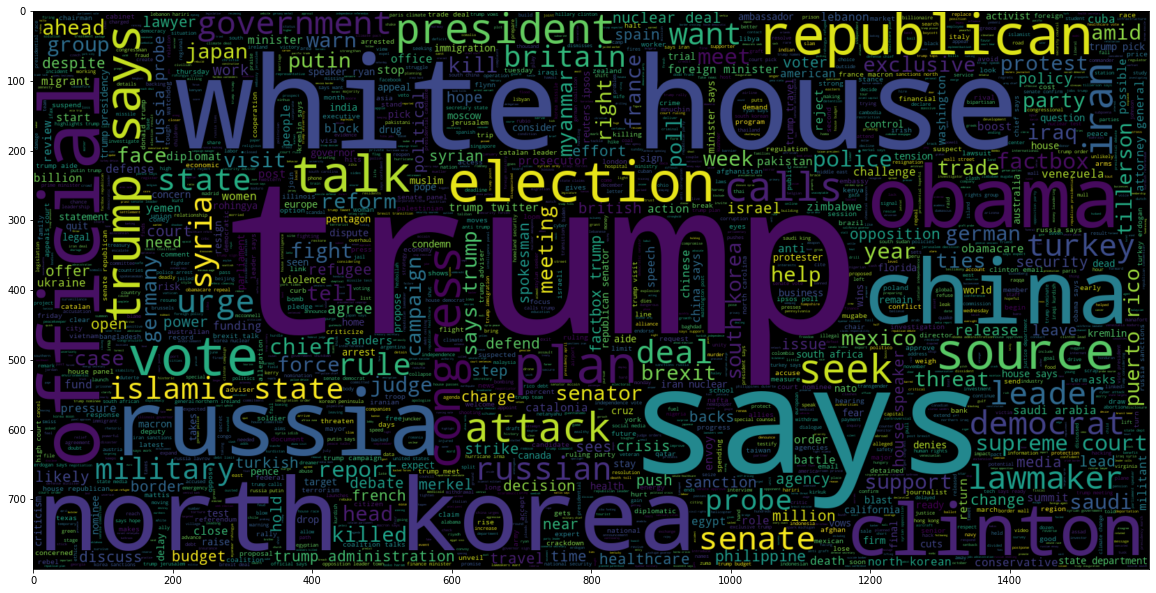

In [33]:
# word cloud for fake news text
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(dffakereal[dffakereal.Type== 1].joinedtext))
plt.imshow(wc, interpolation = 'bilinear')

# word cloud for fake news titles
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(dffakereal[dffakereal.Type== 1].joinedtitle))
plt.imshow(wc, interpolation = 'bilinear')

# word cloud for real news text
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(dffakereal[dffakereal.Type== 0].joinedtext))
plt.imshow(wc, interpolation = 'bilinear')

# word cloud for real news titles
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(dffakereal[dffakereal.Type== 0].joinedtitle))
plt.imshow(wc, interpolation = 'bilinear')

# Splitting Data

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [35]:
x_train.shape, y_train.shape

((35918,), (35918,))

In [36]:
x_test.shape, y_test.shape

((8980,), (8980,))

# TFID Vectorisation Training

In [37]:
tfidvector = TfidfVectorizer(stop_words = 'english')

In [38]:
tfidvector.fit(x_train)

TfidfVectorizer(stop_words='english')

# Apply TFID Vectorisation

In [39]:
tv_train = tfidvector.transform(x_train)

tv_test = tfidvector.transform(x_test)

In [40]:
x_train.shape

(35918,)

In [41]:
tv_train.shape

(35918, 17955)

In [42]:
print(tv_train)

  (0, 15809)	0.2666788766677016
  (0, 11585)	0.4710903230821066
  (0, 6761)	0.2922708924863221
  (0, 6317)	0.5329322610614137
  (0, 4578)	0.4877000854331437
  (0, 2953)	0.31569897280696335
  (1, 17127)	0.35204685910170647
  (1, 13190)	0.23406486938559612
  (1, 12038)	0.45531270691349135
  (1, 9801)	0.3501263218964613
  (1, 8828)	0.3697629426205719
  (1, 8609)	0.3540509236947857
  (1, 6414)	0.4788547308421799
  (2, 17203)	0.1345188452374229
  (2, 16539)	0.10719185946108595
  (2, 12159)	0.36343197152389295
  (2, 10141)	0.27271574556998884
  (2, 9344)	0.35992742499793456
  (2, 8551)	0.3121657300019217
  (2, 6899)	0.3785746066238999
  (2, 6289)	0.42069329182047793
  (2, 2124)	0.4654687281840311
  (3, 12950)	0.5155582916662275
  (3, 12416)	0.5829892886554341
  (3, 9093)	0.3487572373898123
  :	:
  (35914, 9138)	0.31868100067145066
  (35914, 8685)	0.3236703174554692
  (35914, 7140)	0.3065477869889816
  (35914, 4050)	0.35341408470072194
  (35914, 2469)	0.33592422333678423
  (35914, 1579)	0.205

# Logistic regression training

In [43]:
log_model = LogisticRegression( max_iter=1000)
log_model.fit(tv_train, y_train)

LogisticRegression(max_iter=1000)

# Multinomial naive bayes training

In [44]:
nb = MultinomialNB()
nb.fit(tv_train,y_train)

MultinomialNB()

# SVC training

In [45]:
rbf_svc = SVC()
rbf_svc.fit(tv_train,y_train)

SVC()

# MLP training

In [46]:
mlp = MLPClassifier()
mlp.fit(tv_train,y_train)

MLPClassifier()

# Logistic Regression Report

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4255
           1       0.95      0.93      0.94      4725

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


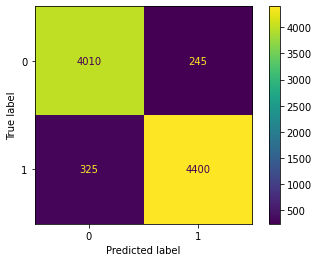

In [47]:
pred = log_model.predict(tv_test) 
#Generate Classification report
print(classification_report(y_test,pred))
#Generate confusion matrix
plot_confusion_matrix(log_model, tv_test, y_test)

# Multinomial Naive Bayes report

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4255
           1       0.92      0.95      0.93      4725

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


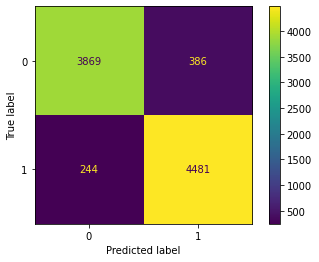

In [48]:
pred = nb.predict(tv_test)    
#Generate classification report
print(classification_report(y_test,pred))
#Generate confusion matrix
plot_confusion_matrix(nb, tv_test, y_test)

# SVC report

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4255
           1       0.96      0.94      0.95      4725

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


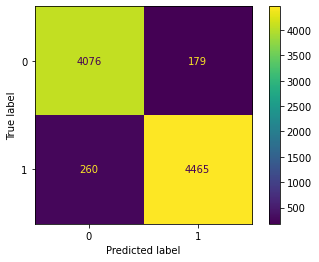

In [49]:
pred = rbf_svc.predict(tv_test) 
#Generate classification report
print(classification_report(y_test,pred))
#Generate confusion matrix
plot_confusion_matrix(rbf_svc, tv_test, y_test)

# MLP report

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4255
           1       0.92      0.94      0.93      4725

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.92      0.92      0.92      8980



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


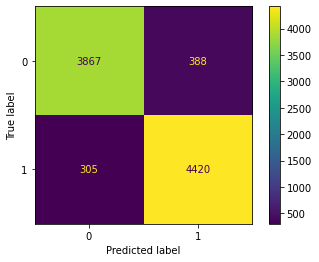

In [50]:
pred = mlp.predict(tv_test)    
#Generate classification report
print(classification_report(y_test,pred))
#Generate confusion matrix
plot_confusion_matrix(mlp, tv_test, y_test)